In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [42]:
!pip install torcheval
from torcheval.metrics import PeakSignalNoiseRatio
metric = PeakSignalNoiseRatio()
metric1 = PeakSignalNoiseRatio()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.8 MB/s eta 0:00:00a 0:00:01m


In [43]:
metric.reset()  # Reset the metric to clear any previous state

In [45]:
metric1.reset()

In [2]:
# Read in a image from torchvision
img = torchvision.io.read_image("/kaggle/input/image-mc-1/multiple_colours.jpg")
print(img.shape)

torch.Size([3, 616, 651])


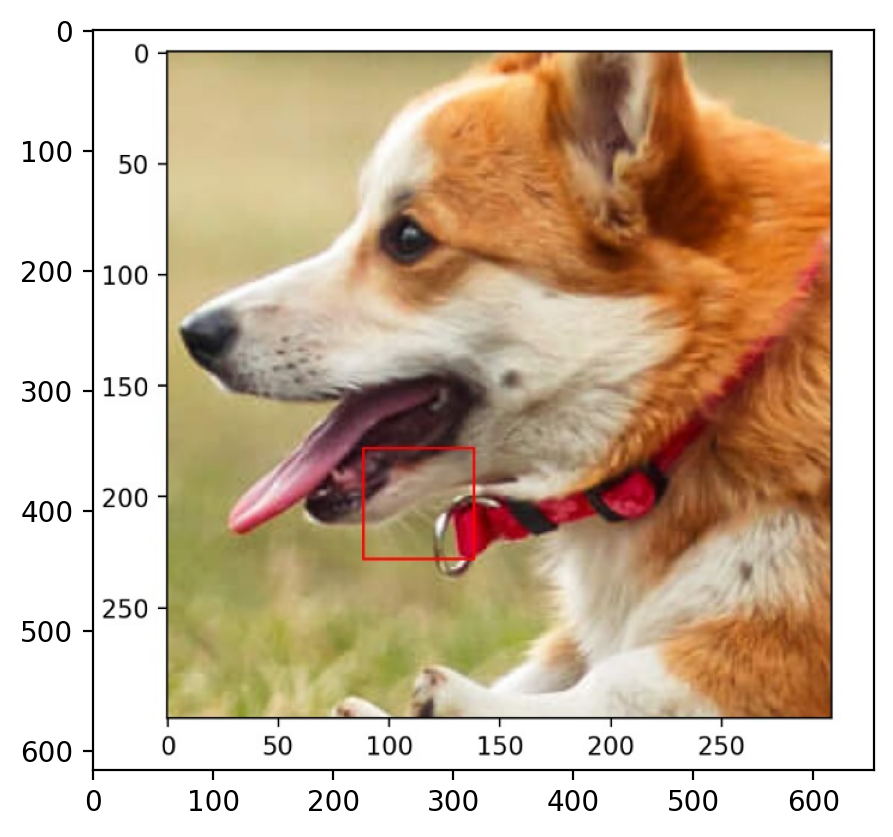

In [3]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [4]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [5]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [6]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0',
       dtype=torch.float64)

In [7]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 100, 100, 400, 400)
crop.shape
# crop=img_scaled
# crop.shape

torch.Size([3, 400, 400])

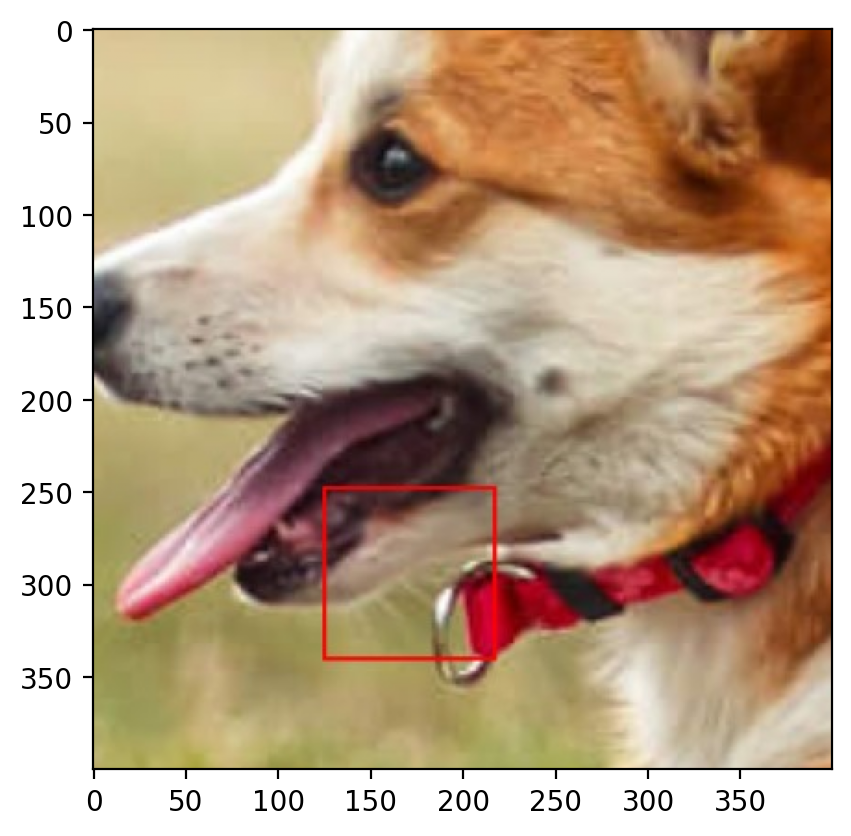

In [8]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [9]:
crop = crop.to(device)


In [10]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 400 400


In [11]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [12]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

(torch.Size([160000, 2]), torch.Size([160000, 3]))

In [13]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [14]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [15]:
net = LinearModel(2, 3)
net.to(device)


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [16]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [17]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

    return outputs

In [18]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [19]:
X_rff = create_rff_features(dog_X_scaled, 20000, 0.008)

In [20]:
X_rff.shape

torch.Size([160000, 20000])

In [21]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.355875
Epoch 100 loss: 0.047644
Epoch 200 loss: 0.012977
Epoch 300 loss: 0.006795
Epoch 400 loss: 0.003945
Epoch 500 loss: 0.002376
Epoch 600 loss: 0.001480
Epoch 700 loss: 0.000957
Epoch 800 loss: 0.000649
Epoch 900 loss: 0.000466
Epoch 1000 loss: 0.000358
Epoch 1100 loss: 0.000294
Epoch 1200 loss: 0.000256
Epoch 1300 loss: 0.000232
Epoch 1400 loss: 0.000217
Epoch 1500 loss: 0.000208
Epoch 1600 loss: 0.000201
Epoch 1700 loss: 0.000196
Epoch 1800 loss: 0.000192
Epoch 1900 loss: 0.000189
Epoch 2000 loss: 0.000187
Epoch 2100 loss: 0.000185
Epoch 2200 loss: 0.000184
Epoch 2300 loss: 0.000183
Epoch 2400 loss: 0.000182


0.00018082869064528495

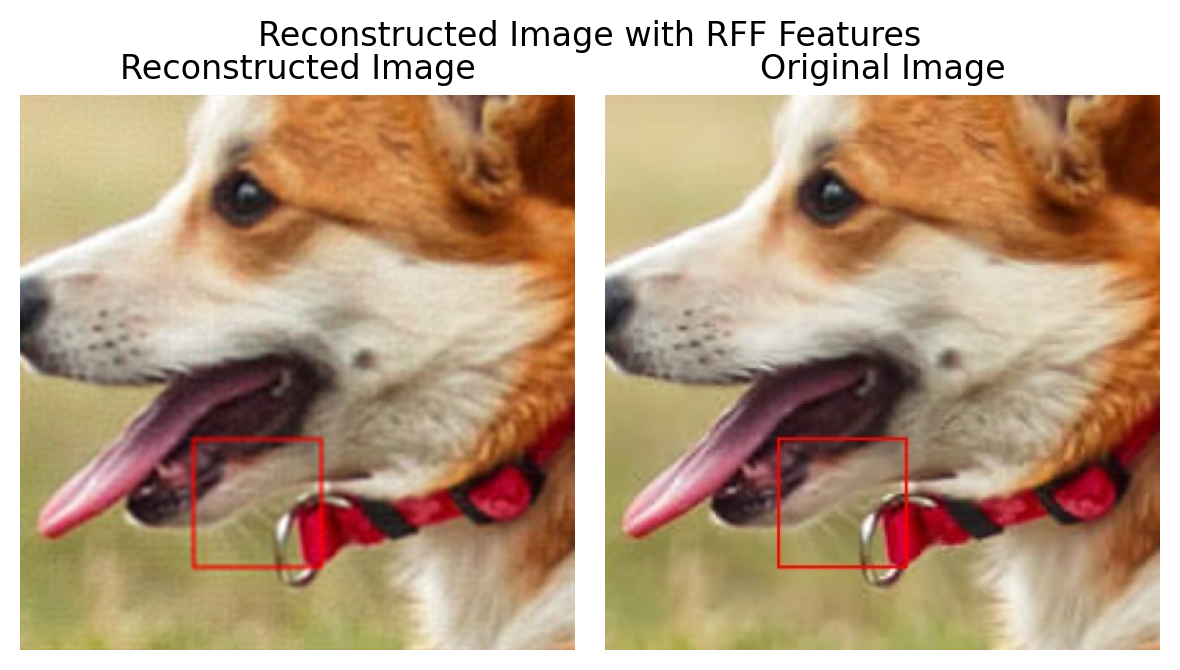

In [22]:
reconstructed_img=plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [31]:
reconstructed_img_rearranged=rearrange(reconstructed_img, 'h w c->c h w' )

In [34]:
reconstructed_img_rearranged = reconstructed_img_rearranged.cpu()

In [35]:
scaler_img_1 = preprocessing.MinMaxScaler().fit(reconstructed_img_rearranged.reshape(-1, 1))
scaler_img_1

MinMaxScaler()

In [36]:
#Normalize the reconstructed_img_rearranged

reconstructed_img_rearranged_rescaled = scaler_img_1.transform(reconstructed_img_rearranged.reshape(-1, 1)).reshape(reconstructed_img_rearranged.shape)
reconstructed_img_rearranged_rescaled=torch.tensor(reconstructed_img_rearranged_rescaled)
print(reconstructed_img_rearranged_rescaled)

tensor([[[0.8336, 0.8429, 0.8485,  ..., 0.5074, 0.5379, 0.5869],
         [0.8287, 0.8414, 0.8484,  ..., 0.4912, 0.5174, 0.5519],
         [0.8244, 0.8403, 0.8473,  ..., 0.4870, 0.5087, 0.5297],
         ...,
         [0.7117, 0.7223, 0.7227,  ..., 0.8409, 0.8435, 0.8274],
         [0.7071, 0.7170, 0.7189,  ..., 0.8176, 0.8156, 0.7895],
         [0.7057, 0.7086, 0.7062,  ..., 0.7913, 0.7891, 0.7554]],

        [[0.7693, 0.7480, 0.7533,  ..., 0.1994, 0.2218, 0.2697],
         [0.7575, 0.7487, 0.7593,  ..., 0.1922, 0.2079, 0.2390],
         [0.7488, 0.7486, 0.7601,  ..., 0.1921, 0.2019, 0.2192],
         ...,
         [0.6629, 0.6910, 0.6912,  ..., 0.6489, 0.6460, 0.6378],
         [0.6518, 0.6764, 0.6778,  ..., 0.6150, 0.6095, 0.5921],
         [0.6429, 0.6560, 0.6509,  ..., 0.5889, 0.5831, 0.5554]],

        [[0.5963, 0.5786, 0.5829,  ..., 0.0298, 0.0390, 0.0962],
         [0.5851, 0.5770, 0.5860,  ..., 0.0252, 0.0247, 0.0622],
         [0.5776, 0.5763, 0.5855,  ..., 0.0301, 0.0234, 0.

In [37]:
#convert into pixel
reconstructed_img_rearranged_rescaled_pixel=reconstructed_img_rearranged_rescaled*255
reconstructed_img_rearranged_rescaled_pixel_int =reconstructed_img_rearranged_rescaled_pixel.type(torch.uint8)
print(reconstructed_img_rearranged_rescaled_pixel_int)

tensor([[[212, 214, 216,  ..., 129, 137, 149],
         [211, 214, 216,  ..., 125, 131, 140],
         [210, 214, 216,  ..., 124, 129, 135],
         ...,
         [181, 184, 184,  ..., 214, 215, 210],
         [180, 182, 183,  ..., 208, 207, 201],
         [179, 180, 180,  ..., 201, 201, 192]],

        [[196, 190, 192,  ...,  50,  56,  68],
         [193, 190, 193,  ...,  49,  53,  60],
         [190, 190, 193,  ...,  48,  51,  55],
         ...,
         [169, 176, 176,  ..., 165, 164, 162],
         [166, 172, 172,  ..., 156, 155, 150],
         [163, 167, 165,  ..., 150, 148, 141]],

        [[152, 147, 148,  ...,   7,   9,  24],
         [149, 147, 149,  ...,   6,   6,  15],
         [147, 146, 149,  ...,   7,   5,  11],
         ...,
         [113, 115, 113,  ..., 122, 122, 118],
         [109, 110, 108,  ..., 113, 111, 104],
         [110, 108, 103,  ..., 108, 105,  93]]], dtype=torch.uint8)


In [38]:
#Crop is already normalized, so convert it into pixel
crop_pixel=crop*255
crop_pixel_int =crop_pixel.type(torch.uint8)
crop_pixel_int=crop_pixel_int.cpu()
print(crop_pixel_int)

tensor([[[219, 219, 219,  ..., 131, 137, 142],
         [219, 219, 219,  ..., 128, 133, 139],
         [220, 220, 220,  ..., 126, 130, 135],
         ...,
         [187, 186, 186,  ..., 218, 217, 216],
         [184, 184, 184,  ..., 211, 211, 210],
         [182, 183, 183,  ..., 202, 202, 200]],

        [[197, 197, 197,  ...,  47,  51,  54],
         [197, 197, 197,  ...,  44,  48,  52],
         [198, 198, 198,  ...,  43,  48,  51],
         ...,
         [173, 172, 172,  ..., 163, 163, 162],
         [170, 170, 170,  ..., 157, 156, 154],
         [168, 169, 170,  ..., 147, 146, 144]],

        [[150, 150, 150,  ...,   1,   2,   4],
         [150, 150, 150,  ...,   1,   2,   4],
         [151, 151, 151,  ...,   0,   1,   4],
         ...,
         [112, 109, 107,  ..., 118, 117, 115],
         [109, 107, 105,  ..., 111, 109, 107],
         [107, 104, 102,  ..., 101,  99,  95]]], dtype=torch.uint8)


In [54]:
#Calc the MSE(Pixel_substraction) and PSNR manually

mse0=torch.mean(((reconstructed_img_rearranged_rescaled_pixel_int[0].float()-crop_pixel_int[0].float()))**2)
mse1=torch.mean(((reconstructed_img_rearranged_rescaled_pixel_int[1].float()-crop_pixel_int[1].float()))**2)
mse2=torch.mean(((reconstructed_img_rearranged_rescaled_pixel_int[2].float()-crop_pixel_int[2].float()))**2)
mse_mean=torch.mean(torch.tensor([mse0,mse1,mse2]))

mx=torch.max(crop_pixel_int.float())
psnr=10*torch.log10((mx**2)/mse_mean)

print("Mse_mean: ",mse_mean)
print("Psnr: ",psnr)

Mse_mean:  tensor(27.2626)
Psnr:  tensor(33.7751)


In [41]:
#Calculating MSE(Pixel_Substraction using torch in built function)

torch.nn.functional.mse_loss(reconstructed_img_rearranged_rescaled_pixel_int.float(), crop_pixel_int.float())

tensor(27.2626)

In [44]:
#Calculating PSNR(Input_Output are in pixel value) using torcheval()

input = reconstructed_img_rearranged_rescaled_pixel_int.float()
target = crop_pixel_int.float()
metric.update(input, target)
print("Psnr :",metric.compute())

Psnr : tensor(33.7751)


In [58]:
#Calc the MSE(Normalized_substraction) and PSNR using manual calc

mse0_1=torch.mean(((reconstructed_img_rearranged_rescaled.cpu()[0].float()-crop.cpu()[0].float()))**2)
mse1_1=torch.mean(((reconstructed_img_rearranged_rescaled.cpu()[1].float()-crop.cpu()[1].float()))**2)
mse2_1=torch.mean(((reconstructed_img_rearranged_rescaled.cpu()[2].float()-crop.cpu()[2].float()))**2)
mse_mean_1=torch.mean(torch.tensor([mse0_1,mse1_1,mse2_1]))

mx_1=torch.max(crop.float())
psnr_1=10*torch.log10((mx_1**2)/mse_mean_1)
print("MSE: ",mse_mean_1)
print("Psnr: ",psnr_1.cpu())

MSE:  tensor(0.0004)
Psnr:  tensor(33.8368)


In [46]:
#Calculating PSNR(Input_Output are normalized) using torcheval()
input = reconstructed_img_rearranged_rescaled.cpu().float()
target = crop.cpu().float()
metric1.update(input, target)
print("Psnr :",metric1.compute())


Psnr : tensor(33.8368)


In [60]:
#   Calculating RMSE_mean using Normalized Data

rmse0 = torch.sqrt(torch.mean(((reconstructed_img_rearranged_rescaled[0].float() - crop[0].cpu().float())) ** 2))
rmse1 = torch.sqrt(torch.mean(((reconstructed_img_rearranged_rescaled[1].float() - crop[1].cpu().float())) ** 2))
rmse2 = torch.sqrt(torch.mean(((reconstructed_img_rearranged_rescaled[2].float() - crop[2].cpu().float())) ** 2))

rmse_mean_norm=torch.mean(torch.tensor([rmse0,rmse1,rmse2]))
print("RMSE: ",rmse_mean_norm)

RMSE:  tensor(0.0203)


In [61]:
#   Calculating RMSE using Normalized Data
rmse_norm = torch.sqrt(torch.mean(((reconstructed_img_rearranged_rescaled.cpu().float() - crop.cpu().float())) ** 2))
print("RMSE: ",rmse_norm)

RMSE:  tensor(0.0203)


In [64]:
#Calculating RMSE_mean manually using pixel

rmse_pixel0 = torch.sqrt(torch.mean(((reconstructed_img_rearranged_rescaled_pixel_int[0].cpu().float() - crop_pixel_int[0].cpu().float())) ** 2))
rmse_pixel1 = torch.sqrt(torch.mean(((reconstructed_img_rearranged_rescaled_pixel_int[1].cpu().float() - crop_pixel_int[1].cpu().float())) ** 2))
rmse_pixel2 = torch.sqrt(torch.mean(((reconstructed_img_rearranged_rescaled_pixel_int[2].cpu().float() - crop_pixel_int[2].cpu().float())) ** 2))
rmse_mean_pixel=torch.mean(torch.tensor([rmse_pixel0,rmse_pixel1,rmse_pixel2]))

print(rmse_mean_pixel)

tensor(5.2209)


In [65]:
#   Calculating RMSE using Pixel using function
rmse_pixel = torch.sqrt(torch.mean(((reconstructed_img_rearranged_rescaled_pixel_int.cpu().float() - crop_pixel_int.cpu().float())) ** 2))
print("RMSE: ",rmse_pixel)

RMSE:  tensor(5.2214)


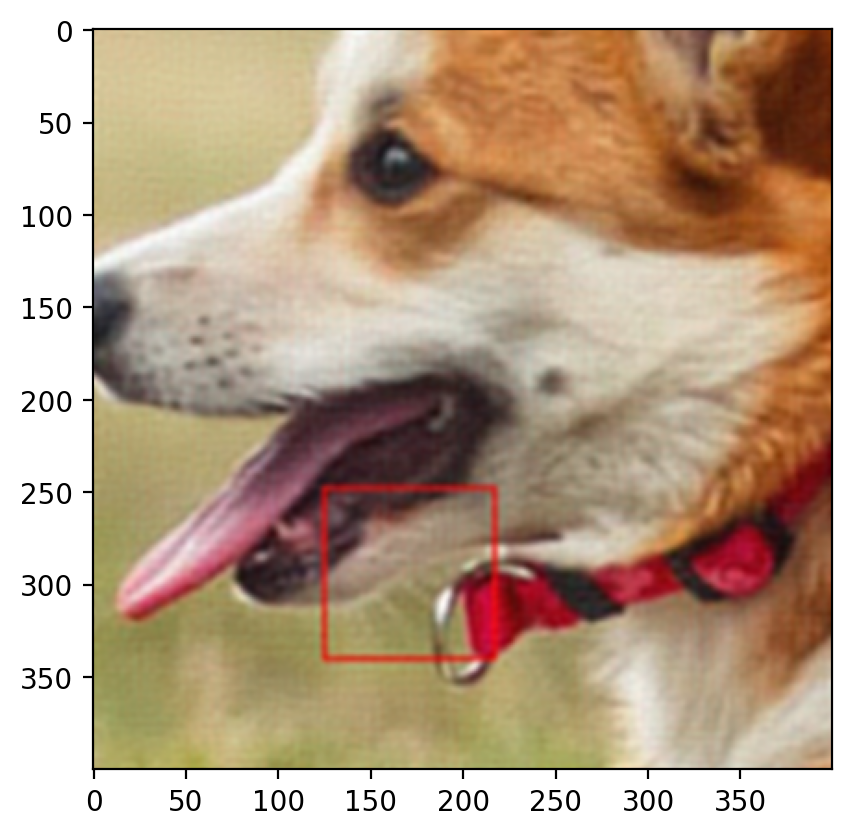

In [40]:
plt.imshow(rearrange(reconstructed_img_rearranged_rescaled_pixel_int, 'c h w -> h w c').cpu().numpy())